In [227]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam


# By Resizing the images to smaller dimensions

In [2]:
sm.set_framework('tf.keras')

In [104]:
def data_loader(folder_dir):
    # folder_dir = "../data/semantic_drone_dataset/training_set/images/"
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset


In [106]:
image_dataset = data_loader("../data/semantic_drone_dataset/training_set/images/")

In [105]:
mask_dataset = data_loader("../data/semantic_drone_dataset/training_set/gt/semantic/label_images/")

In [107]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [108]:
mask_dataset.shape

(400, 128, 128, 3)

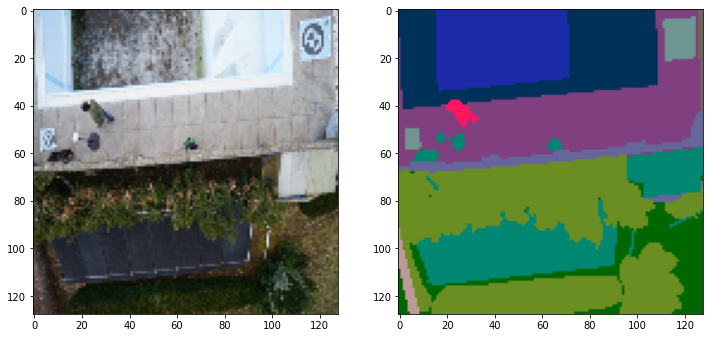

In [13]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [88]:
mask_labels = pd.read_csv('../data/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')

In [97]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [86]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [18]:
labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


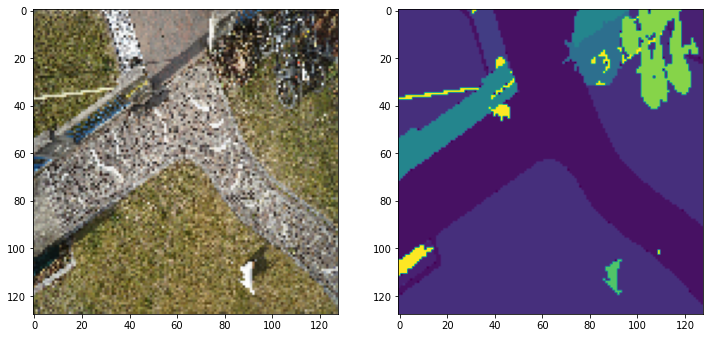

In [19]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [20]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [22]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [24]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [25]:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [26]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [27]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 [==============================] - 19s 149ms/step - loss: 2.6234 - accuracy: 0.3005 - val_loss: 337.0873 - val_accuracy: 0.3743
Epoch 2/100
20/20 [==============================] - 2s 91ms/step - loss: 1.7118 - accuracy: 0.5557 - val_loss: 1746.0358 - val_accuracy: 0.3769
Epoch 3/100
20/20 [==============================] - 2s 85ms/step - loss: 1.4643 - accuracy: 0.5925 - val_loss: 8859.4678 - val_accuracy: 0.2291
Epoch 4/100
20/20 [==============================] - 2s 84ms/step - loss: 1.3476 - accuracy: 0.6230 - val_loss: 2177.6528 - val_accuracy: 0.2544
Epoch 5/100
20/20 [==============================] - 2s 81ms/step - loss: 1.2619 - accuracy: 0.6443 - val_loss: 55.7210 - val_accuracy: 0.3759
Epoch 6/100
20/20 [==============================] - 2s 80ms/step - loss: 1.2030 - accuracy: 0.6553 - val_loss: 78.4555 - val_accuracy: 0.4236
Epoch 7/100
20/20 [==============================] - 2s 86ms/step - loss: 1.1760 - accuracy: 0.6567 - val_loss: 46.9147 - val_accurac

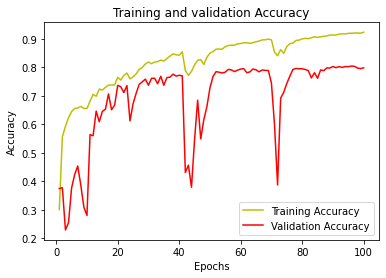

In [28]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# model_resnet_backbone.save('../models/resnet_backbone.hdf5')

In [30]:
model = load_model('../models/resnet_backbone.hdf5')

In [31]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [32]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

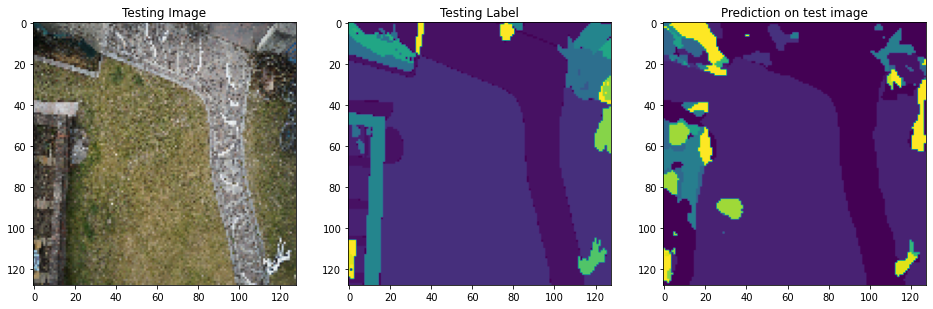

In [33]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

# By Patchifying the Images into smaller images

In [52]:
patch_size = 1000

In [268]:
def patched_data_load(folder_dir, patch_size):
    image_dataset = []
    # scaler = MinMaxScaler()
    random.seed(a=42)
    for images in tqdm(random.sample(os.listdir(folder_dir), 100)):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        # SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        # image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        # image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        image = np.array(image)
        # print("Now patchifying image:", folder_dir+"/"+images)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                #Use minmaxscaler instead of just dividing by 255. 
                # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.   
                single_patch_img = cv2.resize(single_patch_img, (128, 128))
                image_dataset.append(single_patch_img)
    return image_dataset

In [269]:
patched_image_dataset = patched_data_load("../data/semantic_drone_dataset/training_set/images", patch_size)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [270]:
patched_mask_dataset = patched_data_load("../data/semantic_drone_dataset/training_set/gt/semantic/label_images/", patch_size)

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


In [271]:
patched_image_dataset = np.array(patched_image_dataset)

In [272]:
patched_mask_dataset = np.array(patched_mask_dataset)

In [8]:
pickle.dump(patched_image_dataset, open('../data/patched_image_dataset.pkl', 'wb'))

In [7]:
pickle.dump(patched_mask_dataset, open('../data/patched_mask_dataset.pkl', 'wb'))

In [10]:
patched_mask_dataset = pickle.load(open('../data/patched_mask_dataset.pkl', 'rb'))

In [121]:
patched_image_dataset = pickle.load(open('../data/patched_image_dataset.pkl', 'rb'))

In [273]:
patched_image_dataset.shape

(2400, 128, 128, 3)

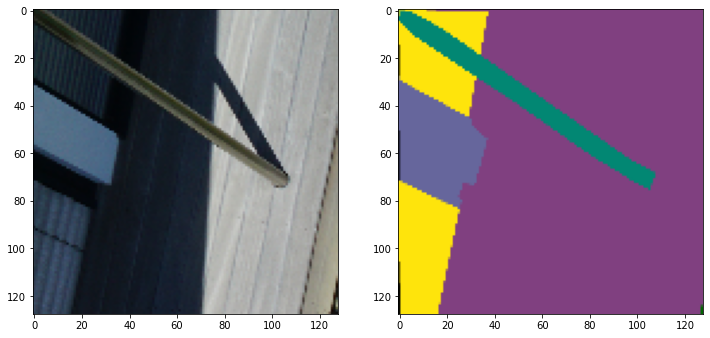

In [274]:
image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_mask_dataset[image_number])
plt.show()

In [275]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    return label_seg

In [276]:
patched_labels = []
for i in tqdm(range(patched_mask_dataset.shape[0])):
    patched_label = rgb_to_labels(patched_mask_dataset[i], mask_labels)
    patched_labels.append(patched_label)

100%|██████████| 2400/2400 [00:27<00:00, 86.56it/s]


In [277]:
patched_labels = np.array(patched_labels)
patched_labels = np.expand_dims(patched_labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


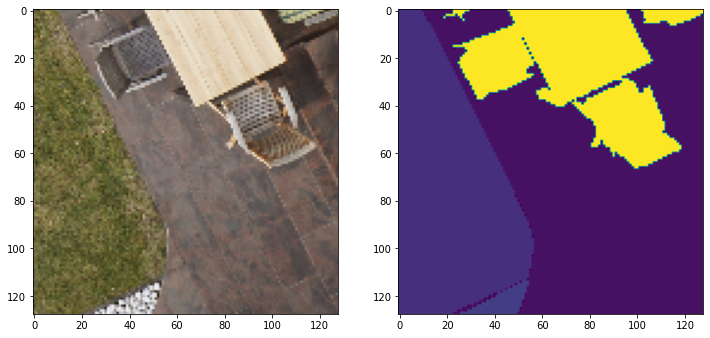

In [279]:
print("Unique labels in label dataset are: ", np.unique(patched_labels))

image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_labels[image_number][:,:,0])
plt.show()

In [280]:
n_classes = len(np.unique(patched_labels))
patched_labels_cat = to_categorical(patched_labels, num_classes=n_classes)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(patched_image_dataset, patched_labels_cat, test_size = 0.20, random_state = 42)

In [282]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [283]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [284]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [285]:
tf.keras.backend.clear_session() # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
metrics=['accuracy']
opt = Adam(learning_rate = 0.002) # Adam optimizer with learning rate 0.001...
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [286]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...
checkpoint = ModelCheckpoint(filepath="../models/patched_resnet_backbone.h5", verbose=2, save_best_only=True)

# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=3)

callbacks = [checkpoint, early_stop]

In [288]:
history1 = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=32, 
          epochs=100,
          callbacks=callbacks,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

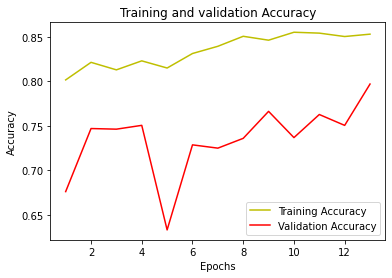

In [251]:
history = history1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [252]:
patched_model = load_model('../models/patched_resnet_backbone.h5')

In [253]:
y_pred=patched_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

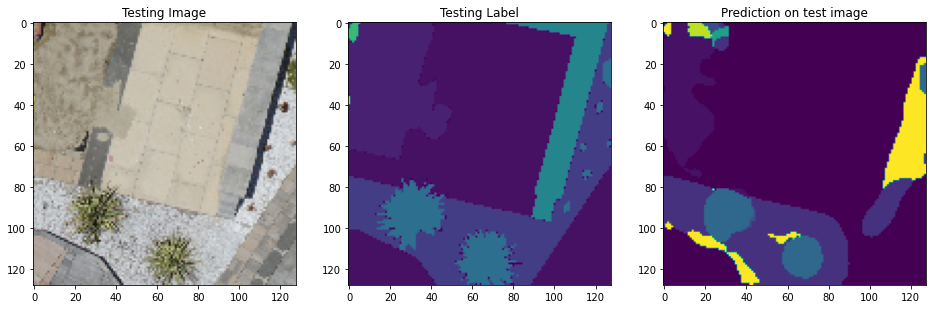

In [267]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (patched_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()